In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
df = pd.read_csv("Data/Joined_Total.csv")
df.head()

CountryOriginCode  Year        REF  IDP  ASY  Fatalities_acled
0               AFG  1979        0.0  0.0    0               NaN
1               AFG  1980  1434921.0  0.0    0               NaN
2               AFG  1981  3879984.0  0.0    0               NaN
3               AFG  1982  4488214.0  0.0    0               NaN
4               AFG  1983  4712735.0  0.0    0               NaN

In [4]:
df.Fatalities_acled.fillna(method="bfill", inplace=True)
df.ASY = df.ASY.astype("float64")

In [5]:
df.head()

CountryOriginCode  Year        REF  IDP  ASY  Fatalities_acled
0               AFG  1979        0.0  0.0  0.0           36349.0
1               AFG  1980  1434921.0  0.0  0.0           36349.0
2               AFG  1981  3879984.0  0.0  0.0           36349.0
3               AFG  1982  4488214.0  0.0  0.0           36349.0
4               AFG  1983  4712735.0  0.0  0.0           36349.0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6387 entries, 0 to 6386
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CountryOriginCode  6387 non-null   object 
 1   Year               6387 non-null   int64  
 2   REF                6387 non-null   float64
 3   IDP                6387 non-null   float64
 4   ASY                6387 non-null   float64
 5   Fatalities_acled   6387 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 299.5+ KB


In [7]:
df.groupby(by="CountryOriginCode")

In [8]:
series = []

for a, b in df.groupby(by="CountryOriginCode"):
    # print(a)
    series.append(b.values[:,2:])

In [9]:
min = 9999999
for serie in series:
    if len(serie) < min:
        min = len(serie)
min

1

In [147]:
def cut_series(serie, years):
    return [a[-years:] for a in serie if len(a[-years:])>=years]

In [148]:
series_2 = cut_series(series, 20)
series_array = np.stack(series_2)
series_array = series_array.astype("float")
series_array.shape

(178, 20, 4)

In [149]:
X_train = series_array[:,:-2,:]
Y_train = series_array[:,-2,:]
X_test = series_array[:,1:-1,:]
Y_test = series_array[:,-1,:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((178, 18, 4), (178, 4), (178, 18, 4), (178, 4))

In [150]:
X_train_max = X_train.max(axis = 1) + 1e-10
X_train_min = X_train.min(axis = 1)

Y_train_max = Y_train.max() + 1e-10
Y_train_min = Y_train.min()

# X_train = (X_train - X_train_min[:,None]) / (X_train_max[:,None] - X_train_min[:,None])
# Y_train = (Y_train - X_train_min) / (X_train_max - X_train_min)

# X_test = (X_test - X_train_min[:,None]) / (X_train_max[:,None] - X_train_min[:,None])
# Y_test = (Y_test - X_train_min) / (X_train_max - X_train_min)

X_train = X_train / X_train_max[:,None, :] #Para que haga broadcasting
Y_train = Y_train / Y_train_max#[:,None]

X_test = X_test / X_train_max[:,None, :]
Y_test = Y_test / Y_train_max#[:,None]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((178, 18, 4), (178, 4), (178, 18, 4), (178, 4))

In [154]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False, input_shape = (18,4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation = "relu")
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               68096     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 20)                2580      
_________________________________________________________________
batch_normalization_4 (Batch (None, 20)                80        
_________________________________________________________________
dense_30 (Dense)             (None, 10)                210       
_________________________________________________________________
batch_normalization_5 (Batch (None, 10)                40        
_________________________________________________________________
dense_31 (Dense)             (None, 4)               

In [155]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mae", metrics = ["mse"])

In [156]:
history = model.fit(X_train.astype("float"), Y_train.astype("float"), batch_size = 32, epochs = 50, validation_data = (X_test.astype("float"), Y_test.astype("float")))

Epoch 1/50
6/6 [==============================] - 1s 96ms/step - loss: 0.3574 - mse: 0.3690 - val_loss: 0.0238 - val_mse: 0.0054
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 0.2402 - mse: 0.1715 - val_loss: 0.0222 - val_mse: 0.0054
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.1954 - mse: 0.1161 - val_loss: 0.0319 - val_mse: 0.0062
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.1470 - mse: 0.0663 - val_loss: 0.0437 - val_mse: 0.0083
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.1228 - mse: 0.0499 - val_loss: 0.0420 - val_mse: 0.0084
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.1071 - mse: 0.0389 - val_loss: 0.0310 - val_mse: 0.0068
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0778 - mse: 0.0238 - val_loss: 0.0244 - val_mse: 0.0059
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0647 - mse: 0.0195 - val

In [42]:
# model.save("PruebaLSTM_Sencilla.h5")

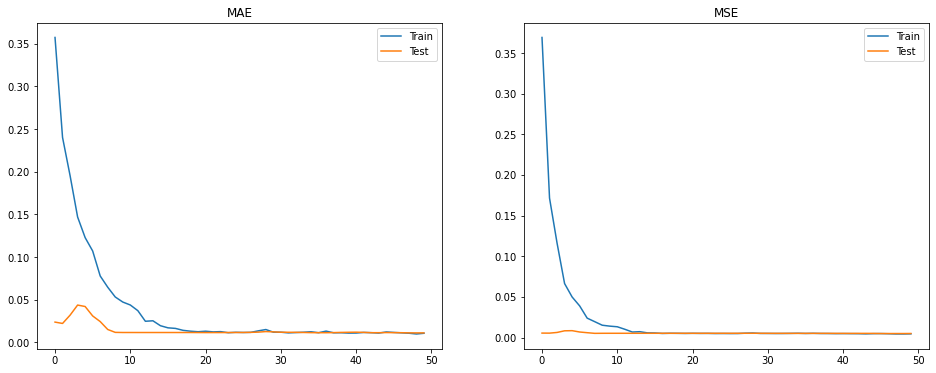

In [157]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.title("MAE")
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.subplot(1,2,2)
plt.title("MSE")
plt.plot(history.history["mse"], label = "Train")
plt.plot(history.history["val_mse"], label = "Test")
plt.legend()
plt.show()

In [81]:
def predict_future(data, steps_in_future=1):
    for i in range(steps_in_future):
        pred = model.predict(data)
        data = np.concatenate((data,pred[:,None,:]), axis = 1)
        data = data[:,1:,:]

    return data[:,-steps_in_future:,:]

In [158]:
predictions_future = predict_future(X_test.astype("float"), 5)

In [159]:
predictions_future.mean(axis = 0)

array([[0.        , 0.00755793, 0.        , 0.        ],
       [0.        , 0.00630437, 0.        , 0.        ],
       [0.00057545, 0.00417096, 0.        , 0.        ],
       [0.00086852, 0.00258911, 0.        , 0.        ],
       [0.        , 0.00180766, 0.        , 0.        ]])

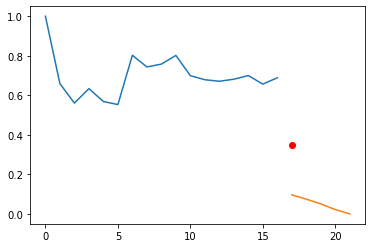

In [146]:
plt.plot(X_test[0][:,0])
plt.plot(range(17,17+5),predictions_future[0][:,0])
plt.plot(17, Y_test[0][0], 'or', label = "Test")
plt.show()

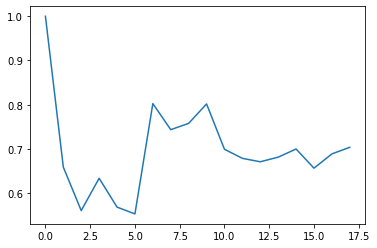

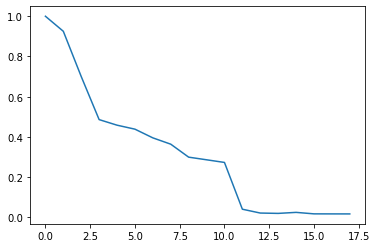

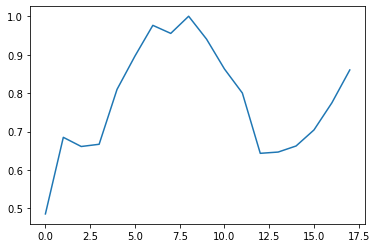

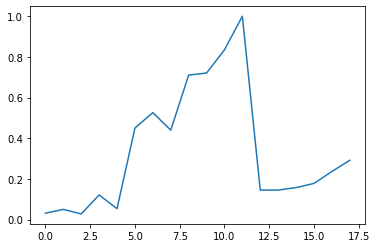

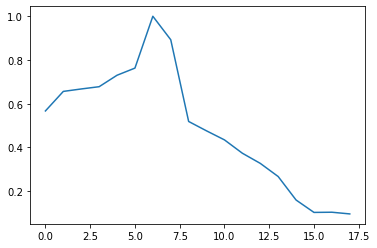

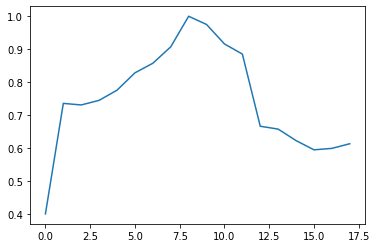

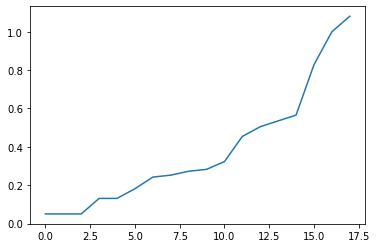

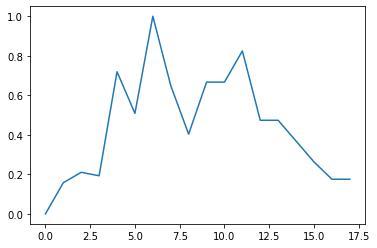

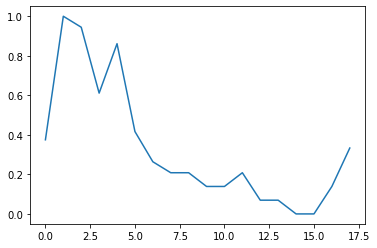

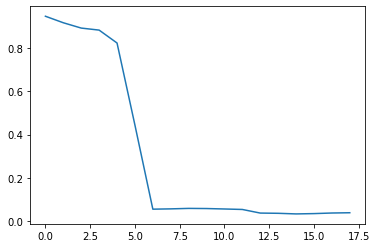

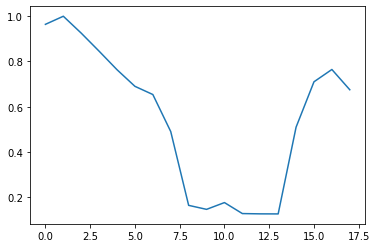

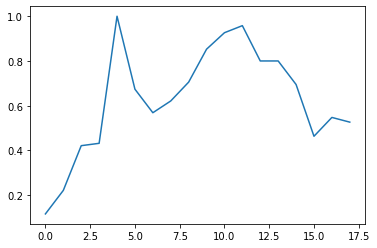

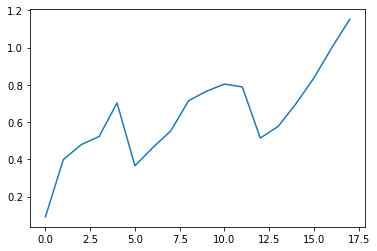

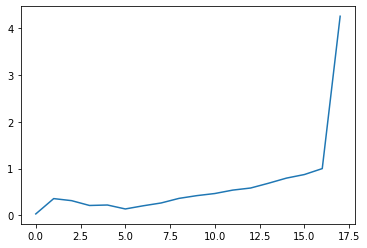

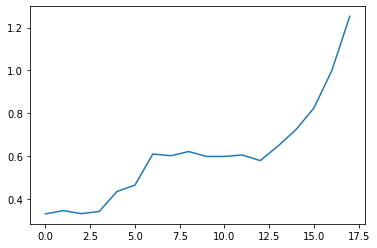

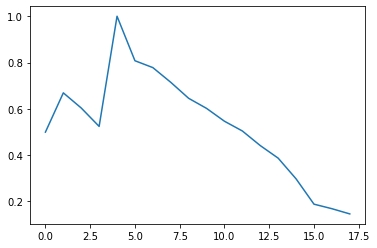

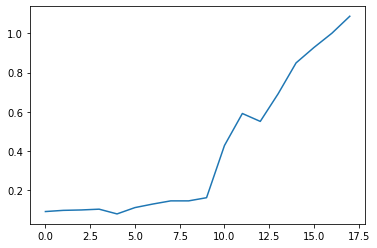

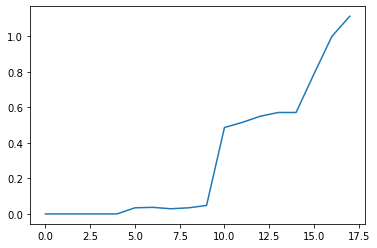

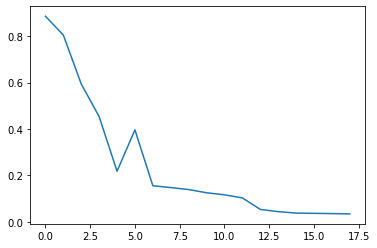

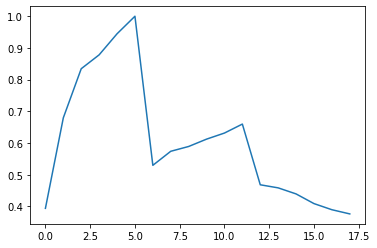

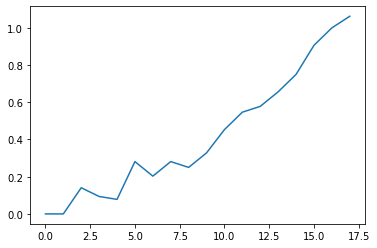

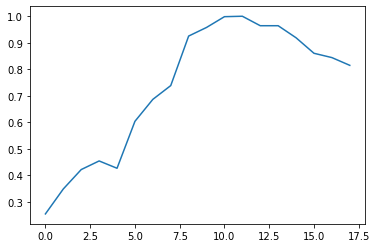

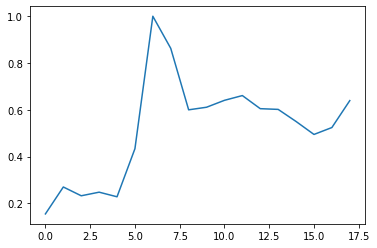

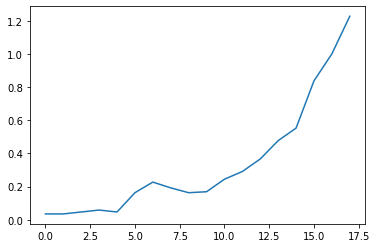

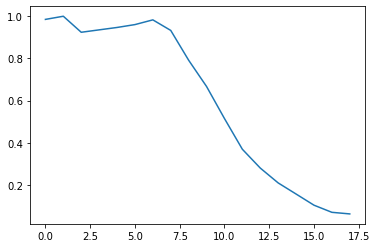

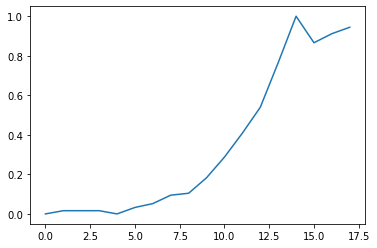

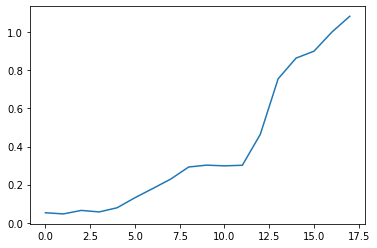

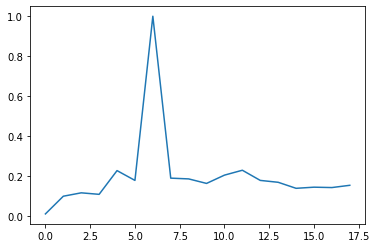

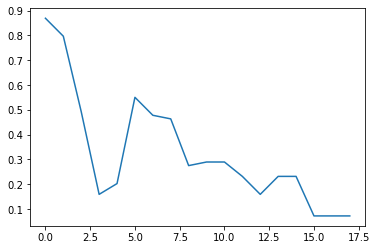

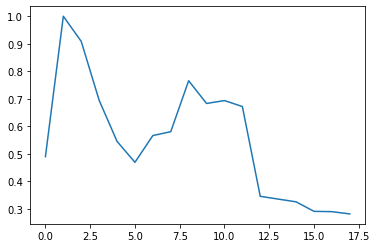

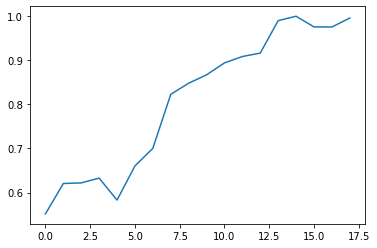

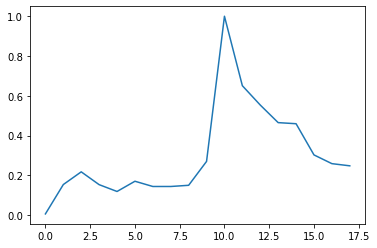

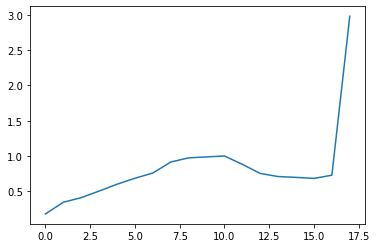

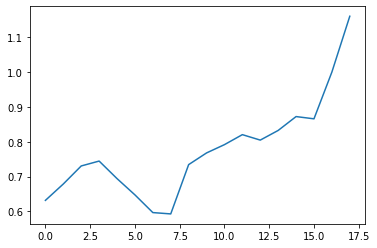

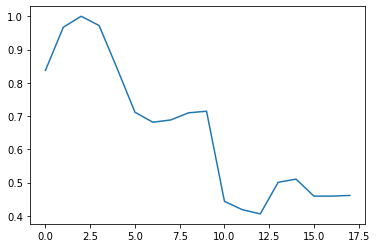

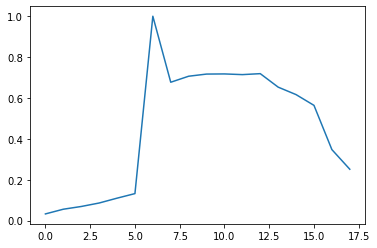

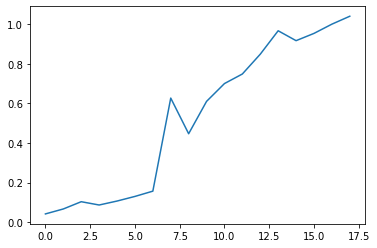

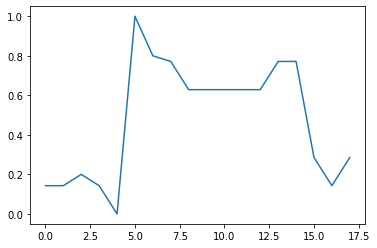

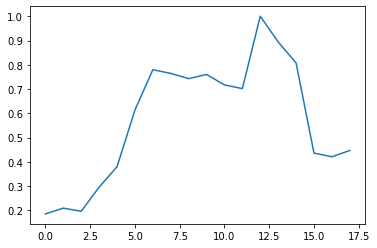

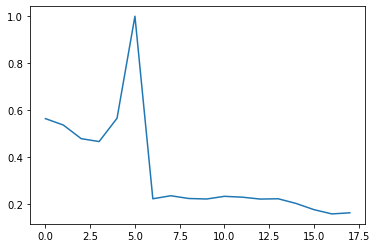

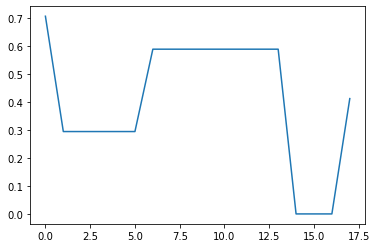

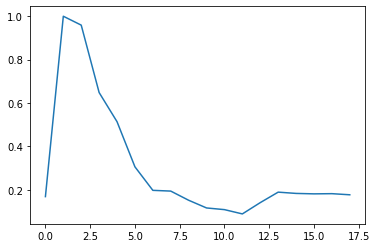

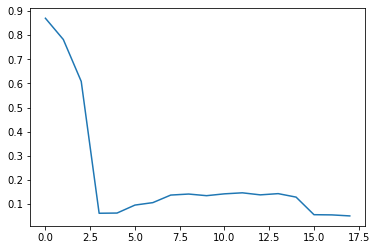

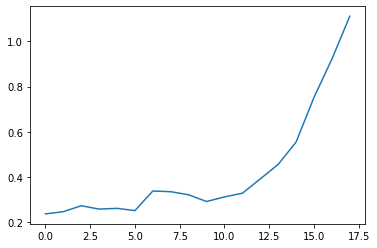

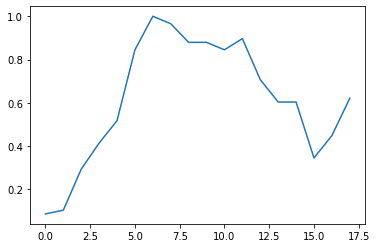

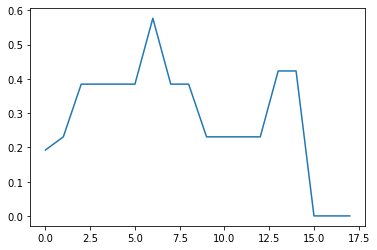

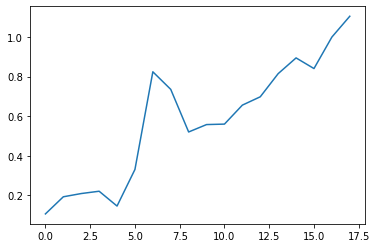

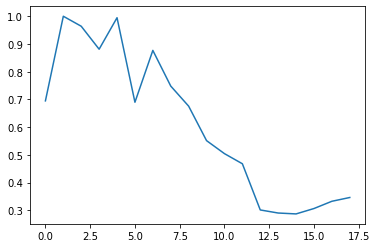

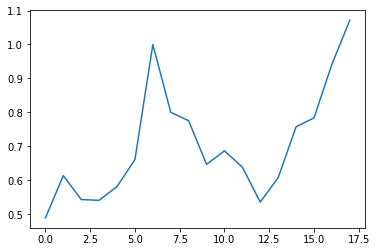

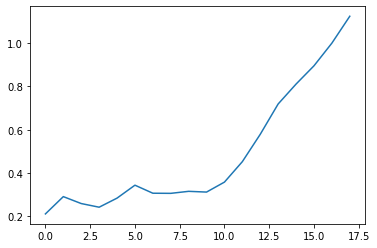

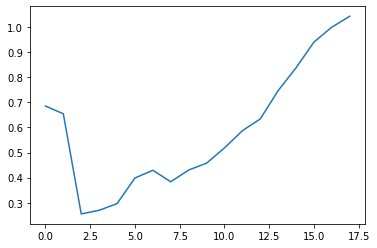

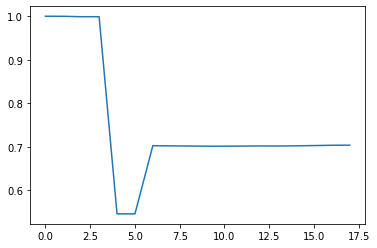

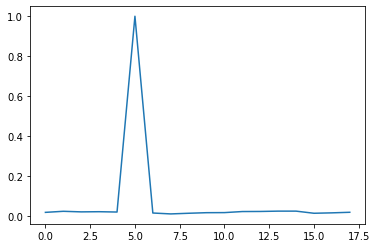

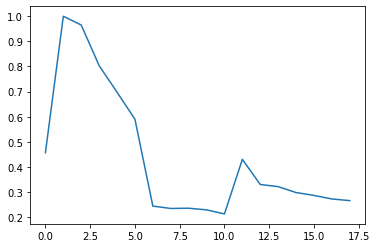

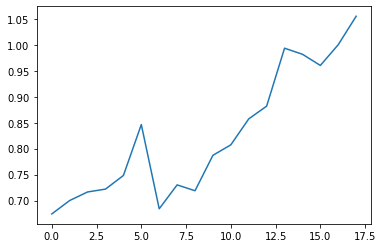

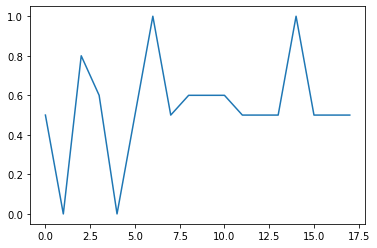

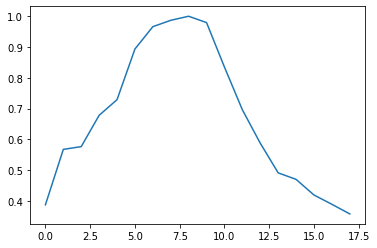

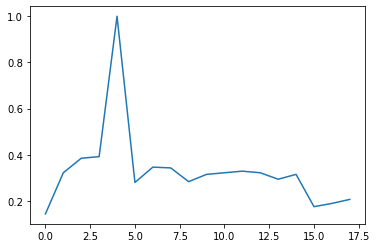

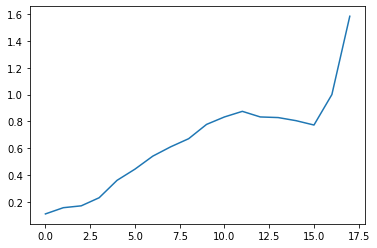

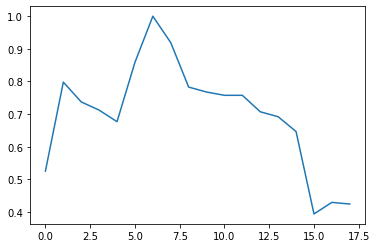

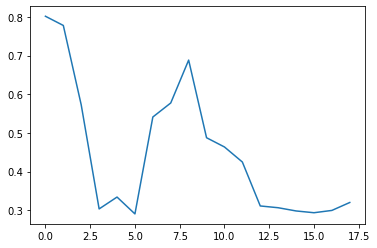

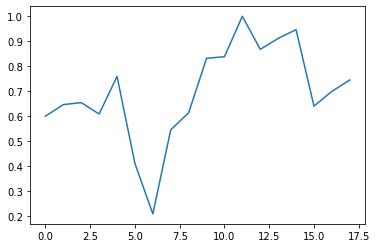

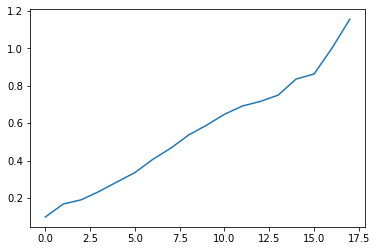

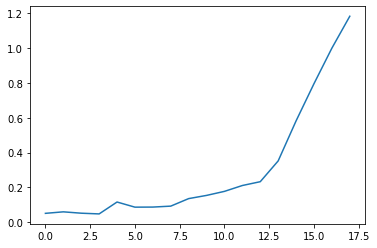

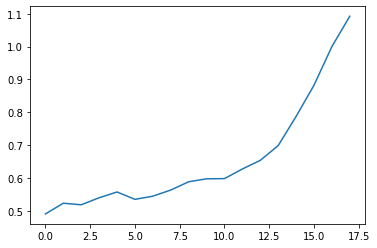

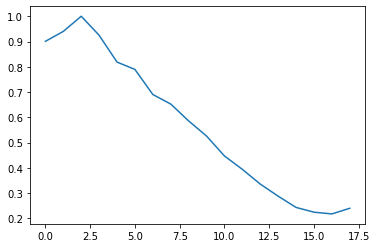

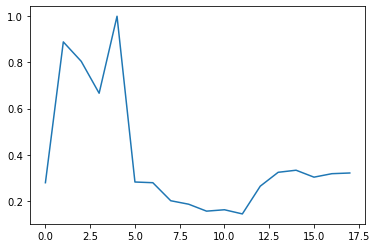

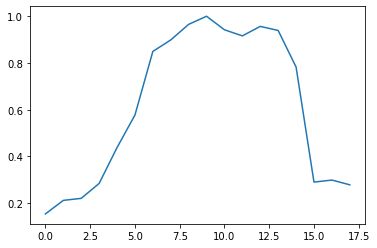

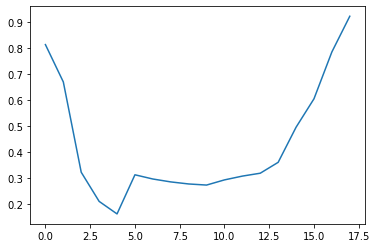

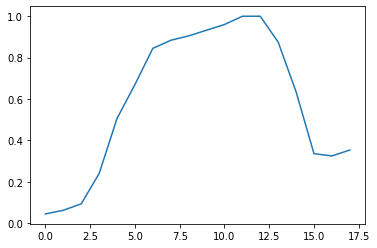

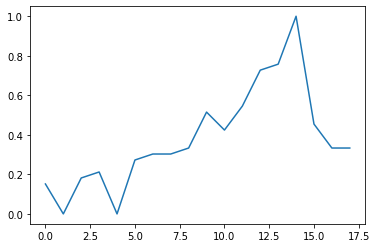

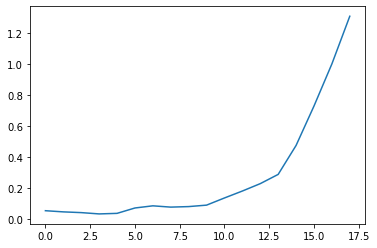

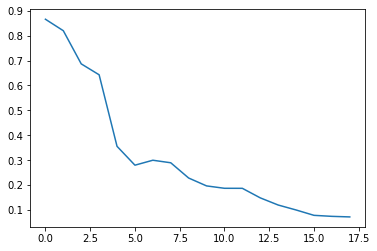

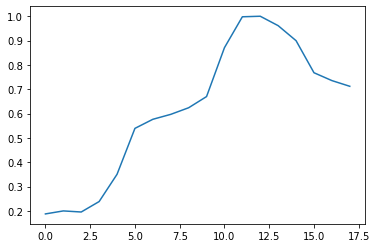

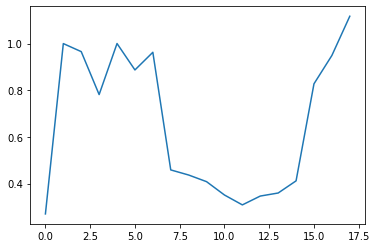

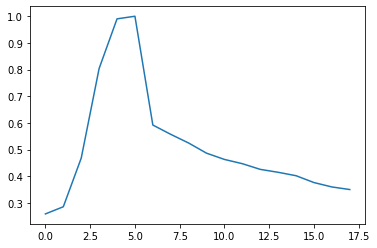

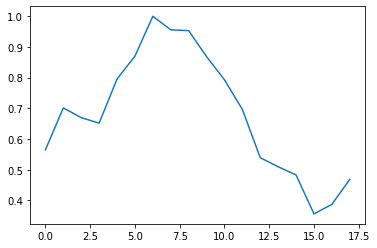

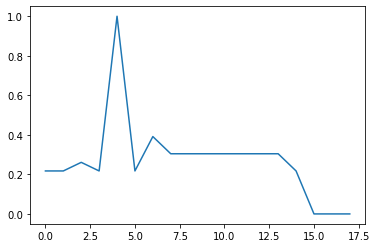

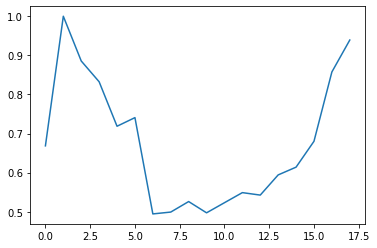

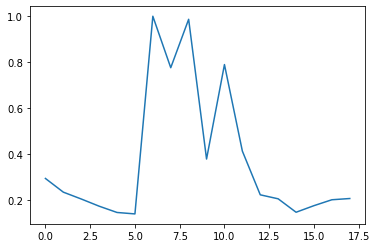

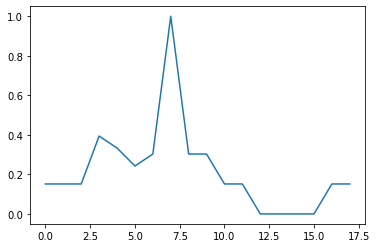

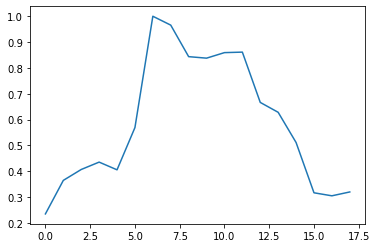

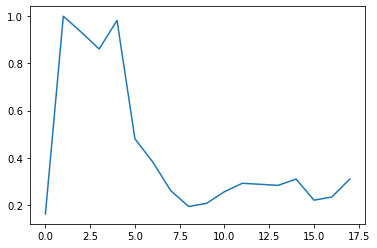

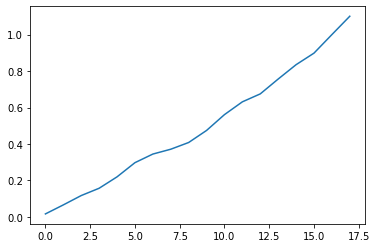

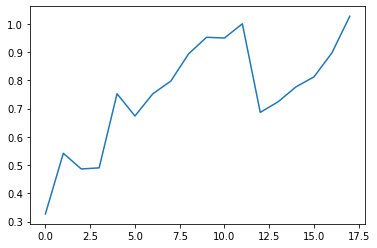

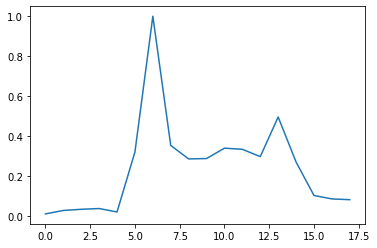

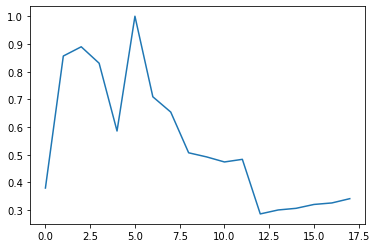

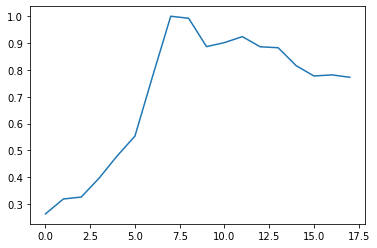

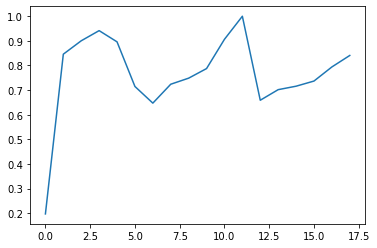

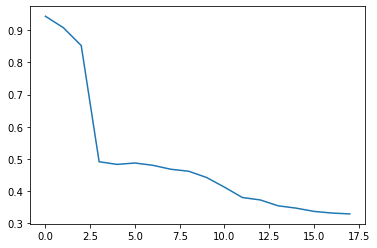

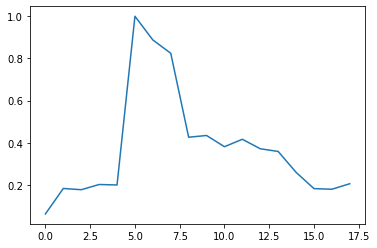

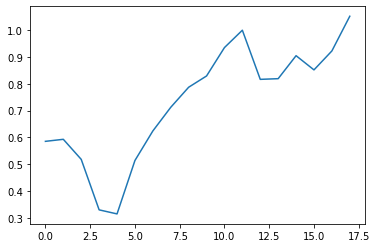

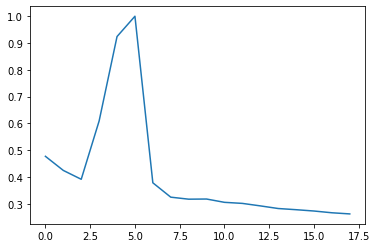

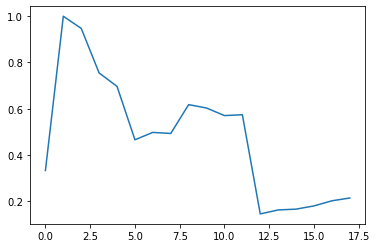

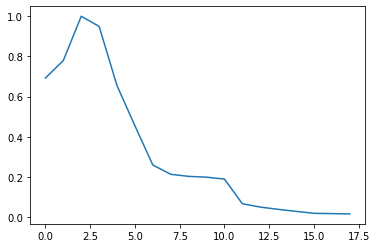

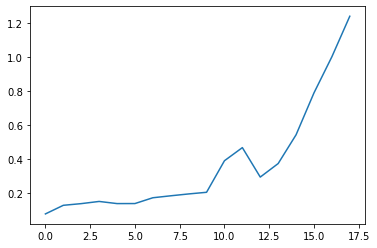

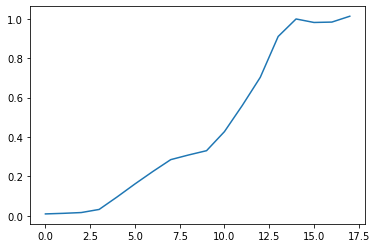

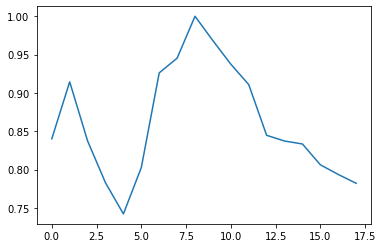

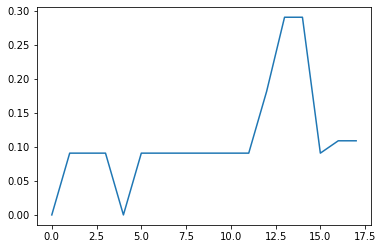

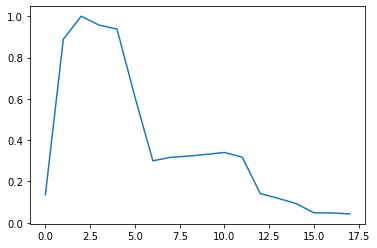

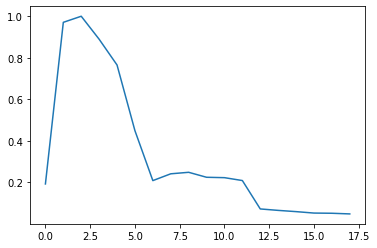

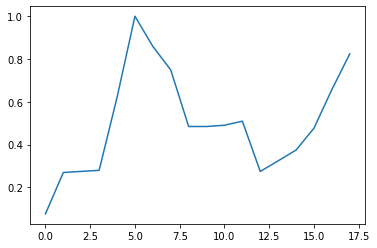

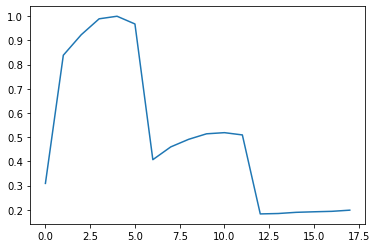

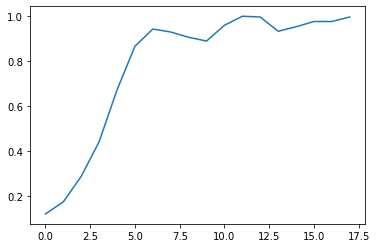

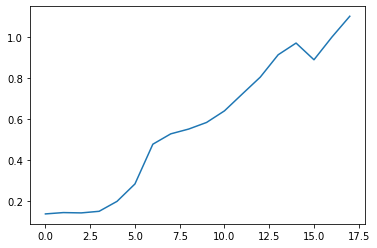

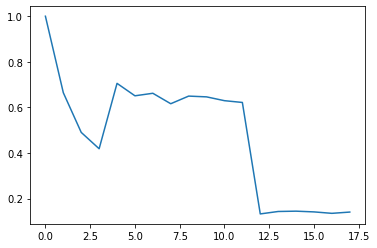

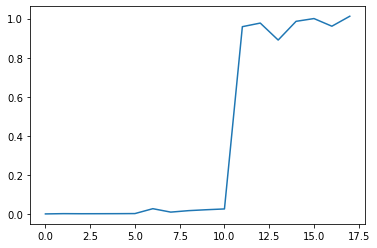

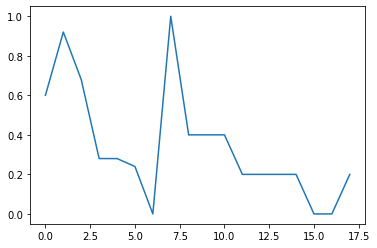

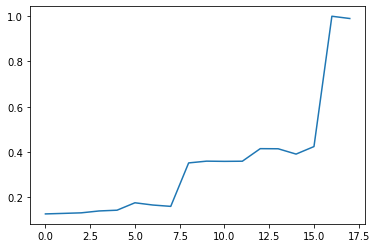

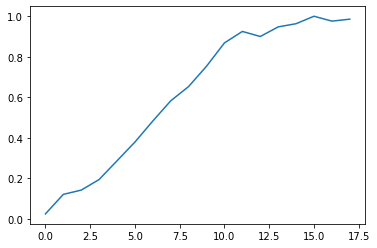

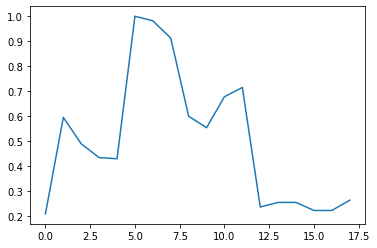

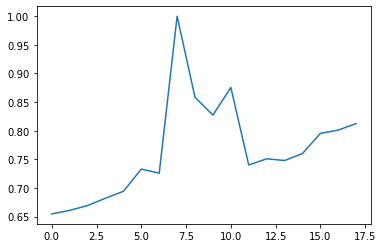

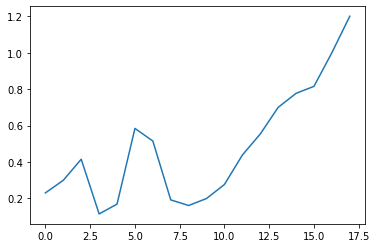

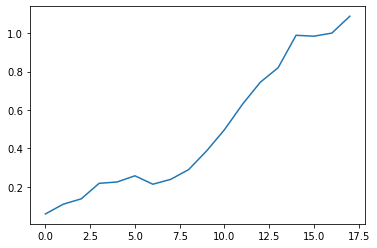

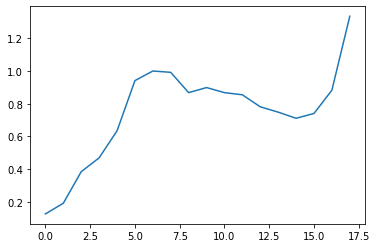

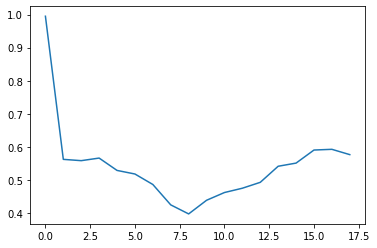

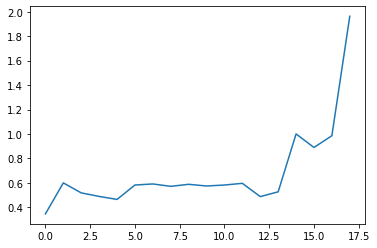

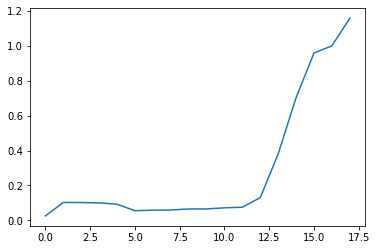

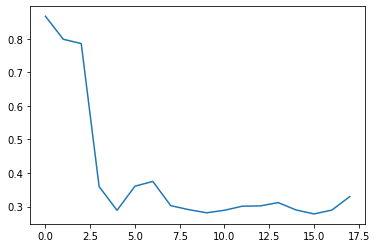

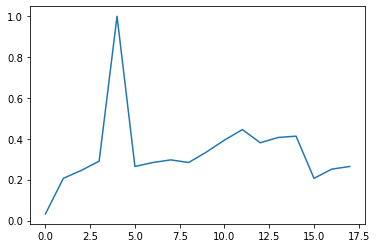

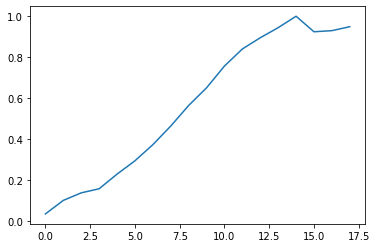

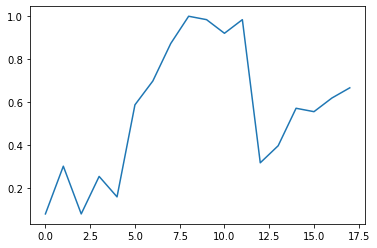

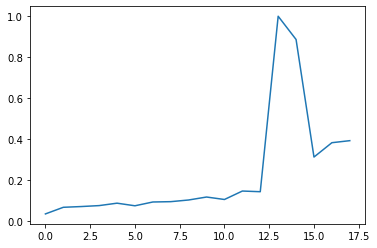

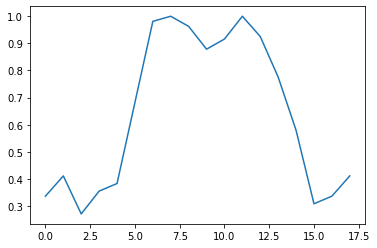

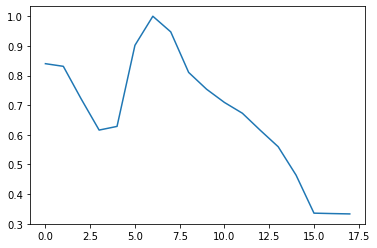

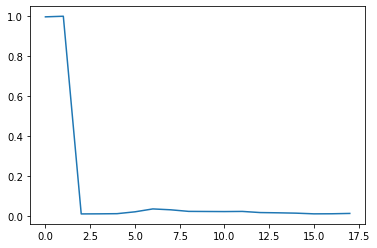

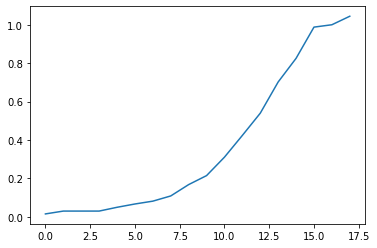

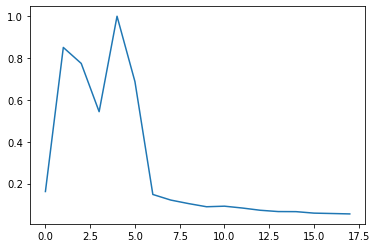

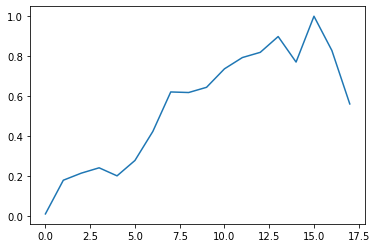

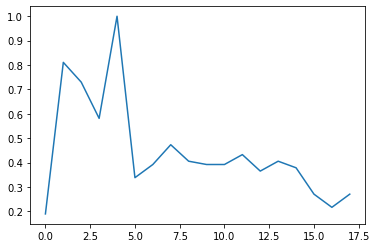

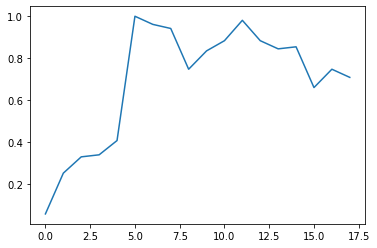

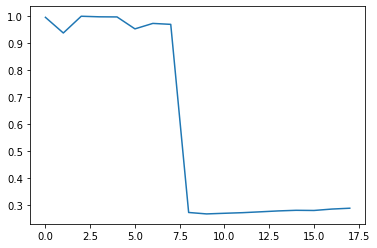

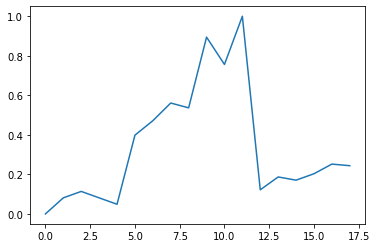

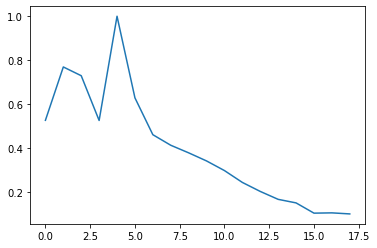

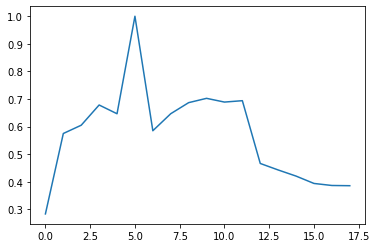

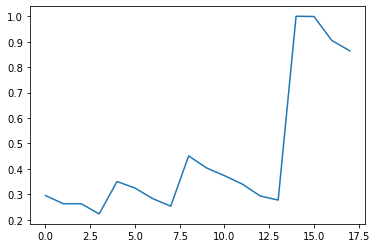

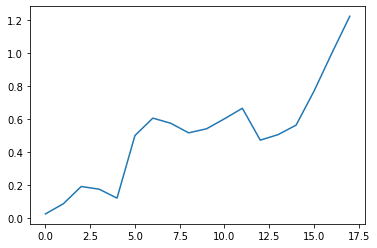

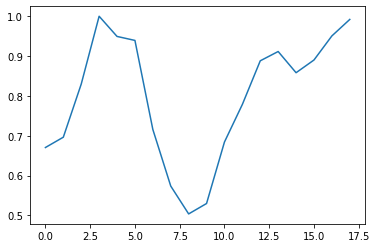

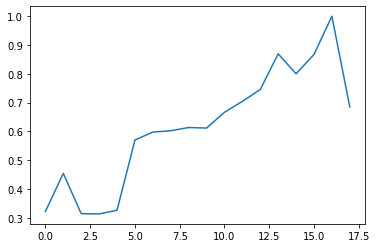

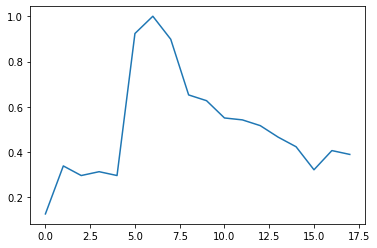

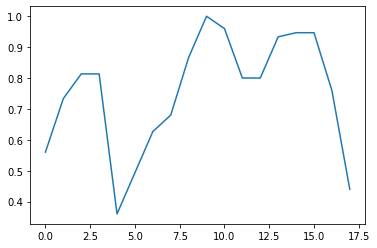

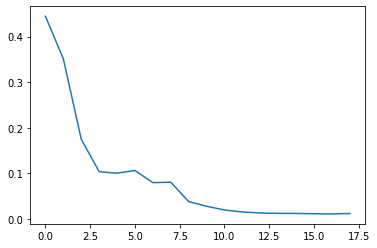

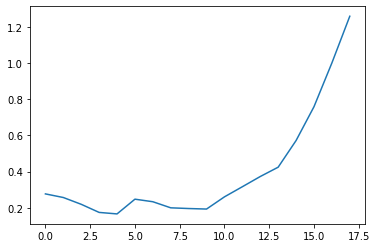

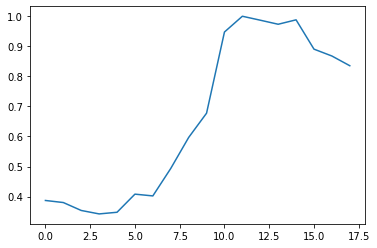

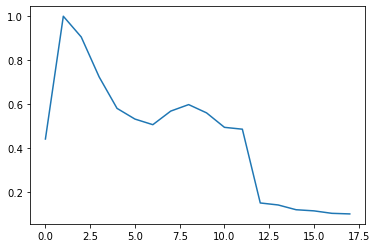

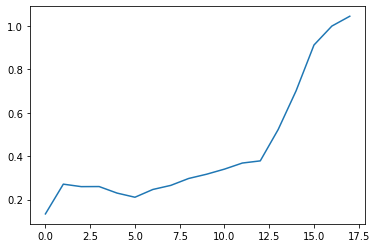

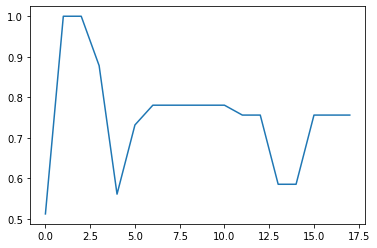

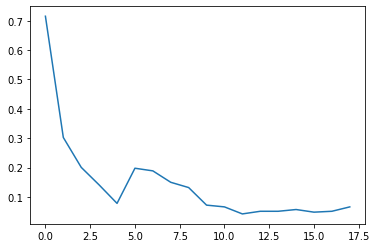

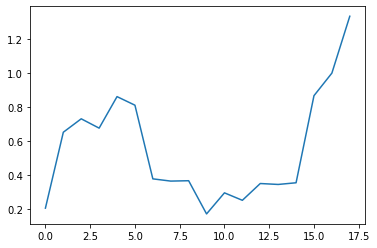

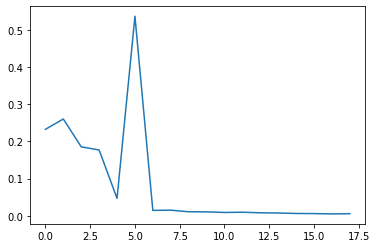

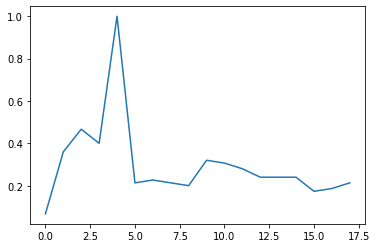

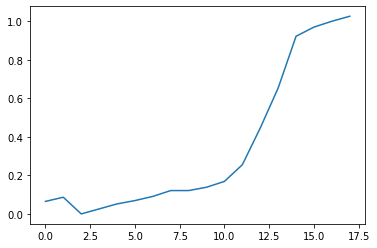

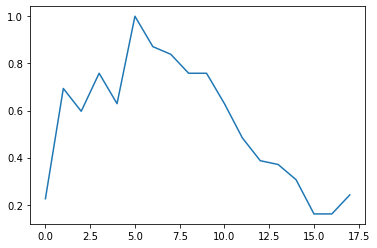

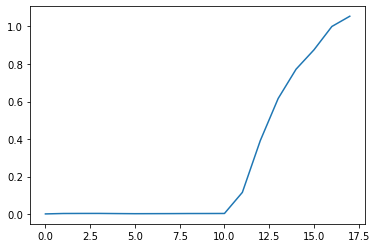

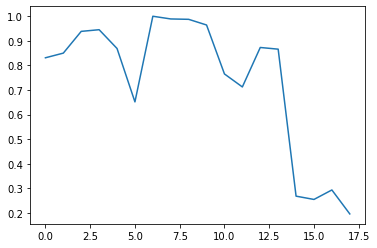

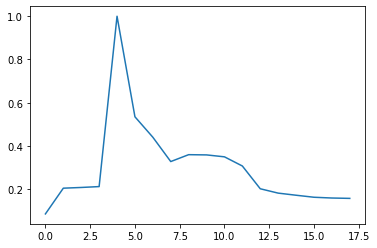

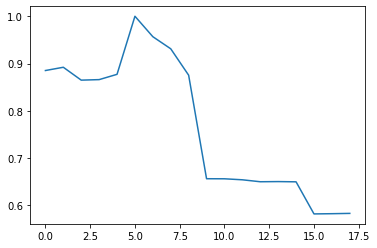

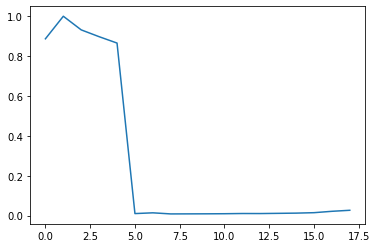

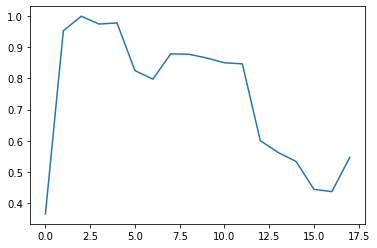

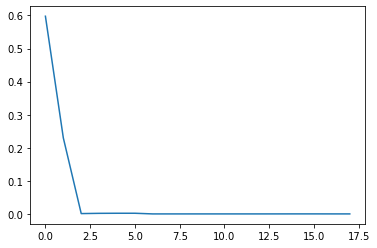

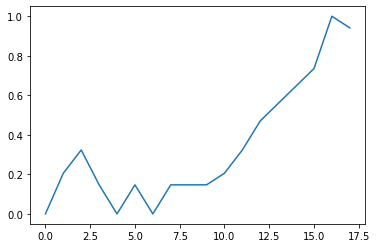

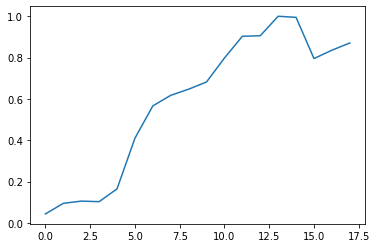

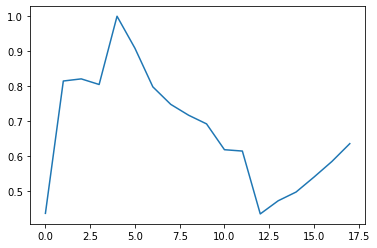

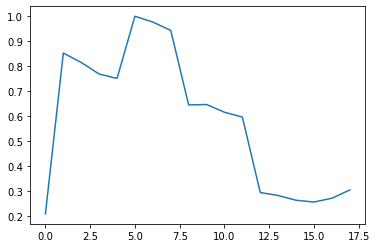

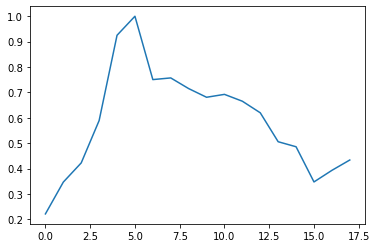

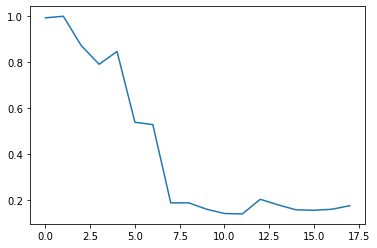

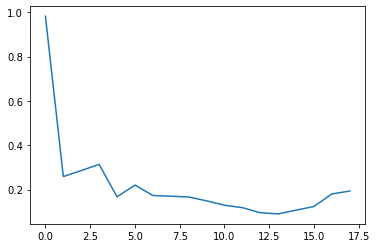

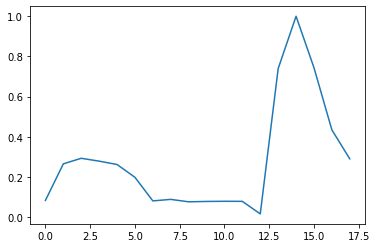

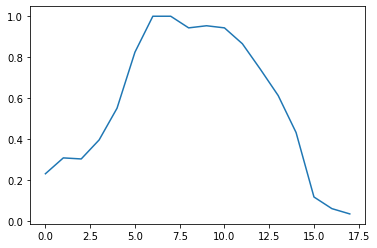

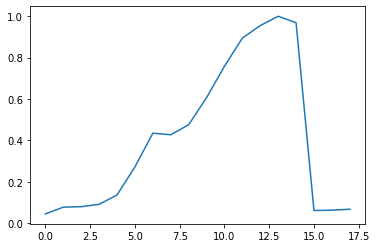

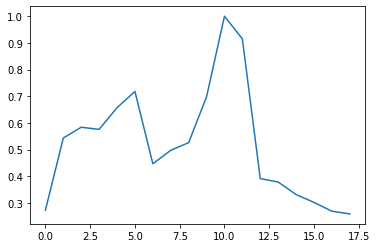

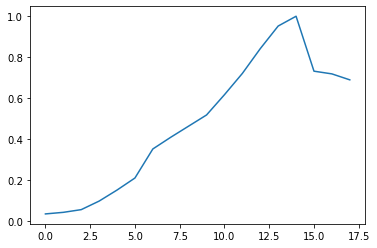

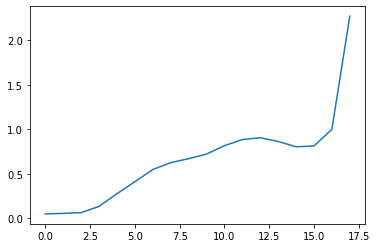

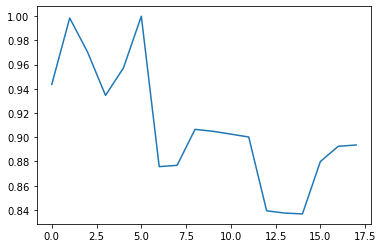

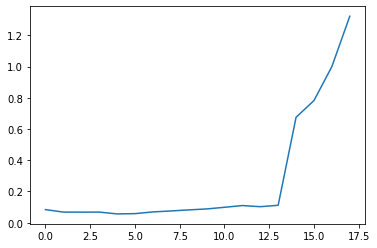

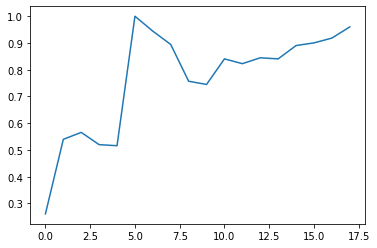

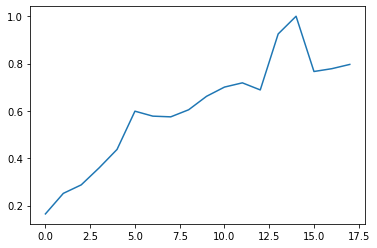

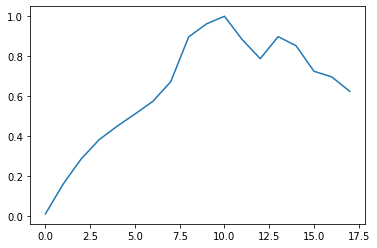

In [78]:
for train in X_test:
    plt.plot(train[:,0])
    plt.show()

In [76]:
class LSTM_Extra(tf.keras.Model):
    def __init__(self, lstm_cells = 18, dense_inputs = 1, outputs = 3):
        super(LSTM_Extra, self).__init__()
        self.lstm = tf.keras.layers.LSTM(lstm_cells, return_sequences = False)
        self.dense_input = tf.keras.layers.Dense(dense_inputs, activation = "relu")
        self.dense_final = tf.keras.layers.Dense(outputs, activation = "linear")

    def call(self, x):
        time_series, static_features = x
        lstm_output = self.lstm(time_series)
        dense_output = self.dense_input(static_features)
        return dense_final((lstm_output, dense_output))